# **U2-Net**

A Pytorch implementation of U2-Net: Going Deeper with Nested U−Structure for Salient Object Detection  
  
**Dataset:** Matting Human Dataset

**Reference:**  
https://araseo08.tistory.com/4  
https://victordibia.com/blog/u-2-net/  

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.utils as utils
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F

import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pickle
from tqdm import tqdm
from time import time

## Hyperparameters

In [2]:
img_size = 256

batch_size = 12
valid_batch_size = 32
epochs = 50
n_print = 100
lr = 1e-4

workers = 2
isCuda = True
device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True
print("Device: {}".format(device))

model_saved_dir = "/content/drive/MyDrive/Colab Notebooks/U2Net"

Device: cuda:0


## Dataset

In [14]:
# Download custom dataset from kaggle
import os.path

if os.path.isfile('~/.kaggle/kaggle.json'):
  print("Already kaggle.json exsits.")
else:
  !mkdir -p ~/.kaggle
  !cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kimjiyeop/matting-human-288x384
if os.path.isdir('./img'):
  print("Already unzip.")
else:
  !unzip -q matting-human-288x384.zip
  print("Unzip Complete!")

matting-human-288x384.zip: Skipping, found more recently modified local copy (use --force to force download)
Already unzip.


In [3]:
class MattingHuman(torch.utils.data.Dataset):
  def __init__(self, split):
    rng = {'train':(0,30984), 'valid':(30984,33925), 'test':(33925, 34425)}
    s, e = rng[split]
    self.nums = [i for i in range(s, e)]

    self.resize = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(256)])
    self.norm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    self.len = e - s
        
  def __getitem__(self, index):
    num = self.nums[index]
    img = cv2.imread('./img/{}.jpg'.format(num))
    mask = cv2.imread('./mask/{}.png'.format(num), cv2.IMREAD_GRAYSCALE)
    
    comb = self.resize(np.concatenate((img, np.expand_dims(mask, axis=2)), axis=2))
    img, mask = self.norm(comb[:3]), comb[3:].squeeze(0)

    return img, mask

  def __len__(self):
    return self.len

In [3]:
# Restore images to suitable images of opencv style
def ImgForPlot(img):
  img = np.einsum('ijk->jki', img)
  img = (127.5*(img+1)).astype(np.uint8)
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
dataset = MattingHuman(split='train')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

valid_dataset = MattingHuman(split='valid')
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=True, num_workers=workers)

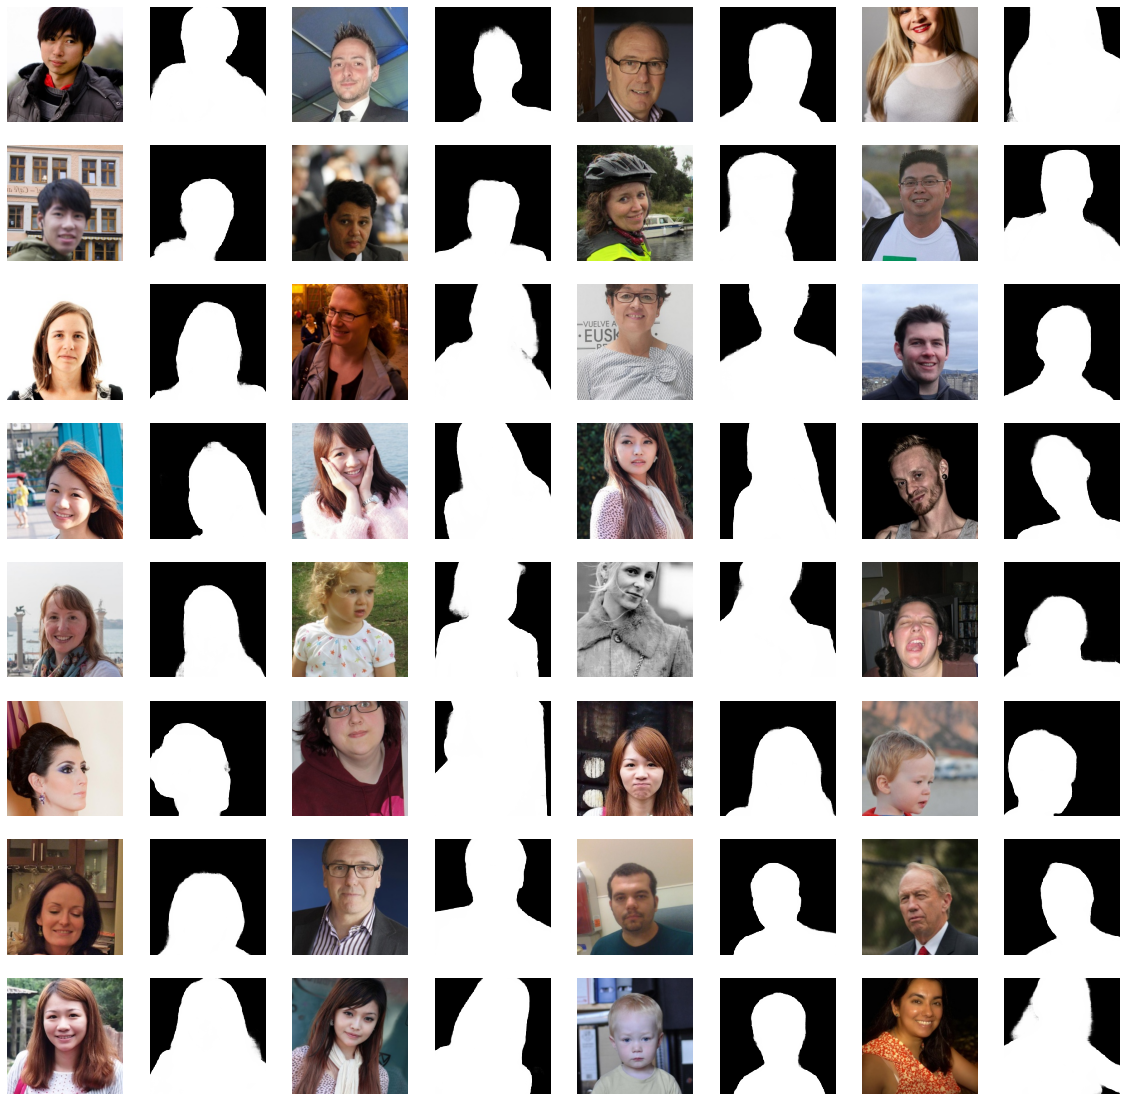

In [ ]:
fig = plt.figure(figsize=(20,20))

for k in range(32):
    img, mask = dataset[k]
    ax = fig.add_subplot(8, 8, 2*k+1)
    ax.imshow(ImgForPlot(img))
    ax.axis("off")
    ax = fig.add_subplot(8, 8, 2*k+2)
    ax.imshow(mask, cmap='gray', vmin=0, vmax=1, interpolation='none')
    ax.axis("off")

plt.show()

## Model

In [4]:
def init_weight(layer):
    nn.init.xavier_uniform_(layer.weight)
    if layer.bias is not None:
        nn.init.constant_(layer.bias, 0)

### Conv + BN + ReLU

In [5]:
class ConvBlock(nn.Module):
  def __init__(self, in_channel, out_channel, dilation=1):
    super(ConvBlock, self).__init__()
    self.conv = nn.Conv2d(in_channel, out_channel, 3, stride=1, padding=dilation, dilation=dilation)
    self.bn = nn.BatchNorm2d(out_channel)
    self.relu = nn.ReLU(inplace = True)
    init_weight(self.conv)

  def forward(self, x):
    return self.relu(self.bn(self.conv(x)))

### RSU

In [6]:
class RSU(nn.Module):
  def __init__(self, L, C_in, C_out, M):
    super(RSU, self).__init__()
    self.conv = ConvBlock(C_in, C_out)
    
    self.enc = nn.ModuleList([ConvBlock(C_out, M)])
    for i in range(L-2):
      self.enc.append(ConvBlock(M, M))
    
    self.mid = ConvBlock(M, M, dilation=2)

    self.dec = nn.ModuleList([ConvBlock(2*M, M) for i in range(L-2)])
    self.dec.append(ConvBlock(2*M, C_out))

    self.downsample = nn.MaxPool2d(2, stride=2)
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

  def forward(self, x):
    x = self.conv(x)
    
    out = []
    for i, enc in enumerate(self.enc):
      if i == 0: out.append(enc(x))
      else: out.append(enc(self.downsample(out[i-1])))
    
    y = self.mid(out[-1])

    for i, dec in enumerate(self.dec):
      if i > 0: y = self.upsample(y)
      y = dec(torch.cat((out[len(self.dec)-i-1], y), dim=1))
    
    return x + y

### RSU4F

In [7]:
class RSU4F(nn.Module):
  def __init__(self, C_in, C_out, M):
    super(RSU4F, self).__init__()
    self.conv = ConvBlock(C_in, C_out)
    
    self.enc = nn.ModuleList([
      ConvBlock(C_out, M),
      ConvBlock(M, M, dilation=2),
      ConvBlock(M, M, dilation=4)
    ])
    
    self.mid = ConvBlock(M, M, dilation=8)

    self.dec = nn.ModuleList([
      ConvBlock(2*M, M, dilation=4),
      ConvBlock(2*M, M, dilation=2),
      ConvBlock(2*M, C_out)
    ])

  def forward(self, x):
    x = self.conv(x)
    
    out = []
    for i, enc in enumerate(self.enc):
      if i == 0: out.append(enc(x))
      else: out.append(enc(out[i-1]))
    
    y = self.mid(out[-1])

    for i, dec in enumerate(self.dec):
      y = dec(torch.cat((out[len(self.dec)-i-1], y), dim=1))
    
    return x + y

### U2-Net

In [8]:
class U2Net(nn.Module):
  def __init__(self):
    super(U2Net, self).__init__()
    self.enc = nn.ModuleList([
      RSU(L=7, C_in=3, C_out=64, M=32),
      RSU(L=6, C_in=64, C_out=128, M=32),
      RSU(L=5, C_in=128, C_out=256, M=64),
      RSU(L=4, C_in=256, C_out=512, M=128),
      RSU4F(C_in=512, C_out=512, M=256),
      RSU4F(C_in=512, C_out=512, M=256)
    ])

    self.dec = nn.ModuleList([
      RSU4F(C_in=1024, C_out=512, M=256),
      RSU(L=4, C_in=1024, C_out=256, M=128),
      RSU(L=5, C_in=512, C_out=128, M=64),
      RSU(L=6, C_in=256, C_out=64, M=32),
      RSU(L=7, C_in=128, C_out=64, M=16)
    ])

    self.convs = nn.ModuleList([
      nn.Conv2d(64, 1, 3, padding=1),
      nn.Conv2d(64, 1, 3, padding=1),
      nn.Conv2d(128, 1, 3, padding=1),
      nn.Conv2d(256, 1, 3, padding=1),
      nn.Conv2d(512, 1, 3, padding=1),
      nn.Conv2d(512, 1, 3, padding=1)
    ])

    self.lastconv = nn.Conv2d(6, 1, 1)
    self.downsample = nn.MaxPool2d(2, stride=2)

    init_weight(self.lastconv)
    for conv in self.convs:
      init_weight(conv)

  def upsample(self, x, target):
    return F.interpolate(x, size=target.shape[2:], mode='bilinear')

  def forward(self, x):
    enc_out = []
    for i, enc in enumerate(self.enc):
      if i == 0: enc_out.append(enc(x))
      else: enc_out.append(enc(self.downsample(enc_out[i-1])))

    dec_out = [enc_out[-1]]
    for i, dec in enumerate(self.dec):
      dec_out.append(dec(torch.cat((self.upsample(dec_out[i], enc_out[4-i]), enc_out[4-i]), dim=1)))
    
    side_out = []
    for i, conv in enumerate(self.convs):
      if i == 0: side_out.append(conv(dec_out[5]))
      else: side_out.append(self.upsample(conv(dec_out[5-i]), side_out[0]))
    
    side_out.append(self.lastconv(torch.cat(side_out, dim=1)))       

    return [torch.sigmoid(s.squeeze(1)) for s in side_out]

## Training

In [9]:
model = U2Net().cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)

### (Option) Load Model

In [10]:
model_name = 'u2net-matting-human'

loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
model_path = F"{model_saved_dir}/{model_name}.pt"

with open(loss_path, 'rb') as f:
  losses = pickle.load(f)

model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Training Model

In [13]:
import math

def update_lr(epoch, T):
  # Decrease lr every T epochs
  new_lr = lr * math.pow(0.5, epoch // T)
  print('Learning Rate: %.6f' % new_lr)
  for param_group in optimizer.param_groups:
    param_group['lr'] = new_lr

In [14]:
model_name = 'u2net-matting-human'

loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
best_model_path = F"{model_saved_dir}/{model_name}_best.pt"
model_path = F"{model_saved_dir}/{model_name}.pt"

start_epoch = 49

if start_epoch == 0:
  losses = {'train': [], 'valid': []}
  best_loss = float("inf")
else:
  best_loss = min(losses['valid'])

BCE = nn.BCELoss(reduction='mean')  # Train
MAE = nn.L1Loss(reduction='mean')   # Validation

for ep in range(start_epoch, epochs):
  update_lr(ep, 8)
  step, loss_sum = 0, 0.
  timestamp = time()
  for batch_idx, (input, target) in enumerate(dataloader, 0):
    input = input.cuda()
    target = target.cuda()
    step += 1
    
    # Train Model
    model.train()
    optimizer.zero_grad()
    
    out = model(input)
    each_loss = [BCE(o, target) for o in out]
    loss = sum(each_loss)
    
    loss.backward()
    optimizer.step()

    # Append Loss
    losses['train'].append(loss.item())
    loss_sum += loss.item()

    if (batch_idx+1) % n_print == 0 or batch_idx == (len(dataloader)-1):
      print('[%2d/%2d][%4d/%4d] Train: %.4f (%ds)' % (ep+1, epochs, batch_idx+1, len(dataloader), loss_sum/step, time() - timestamp))
      step, loss_sum = 0, 0.
      timestamp = time()
      
  # Evaluate Model
  model.eval()
  step, loss_sum = 0, 0.
  timestamp = time()
  with torch.no_grad():
    for input, target in tqdm(valid_dataloader):
      out = model(input.cuda())[-1]
      loss_sum += MAE(out, target.cuda()).item() * input.size(0)
      step += input.size(0)
  
  val_loss = loss_sum / step
  losses['valid'].append(val_loss)
  if val_loss < best_loss:
    best_loss = val_loss
    torch.save(model.state_dict(), best_model_path)

  print('[%2d/%2d] Valid: %.4f (Best: %.4f) (%ds)' % (ep+1, epochs, val_loss, best_loss, time() - timestamp))

  torch.save(model.state_dict(), model_path)
  with open(loss_path, 'wb') as f:
      pickle.dump(losses, f)
  
  print("Saved model completely!")

Learning Rate: 0.000002
[50/50][ 100/2582] Train: 0.1885 (87s)
[50/50][ 200/2582] Train: 0.1894 (76s)
[50/50][ 300/2582] Train: 0.1861 (77s)
[50/50][ 400/2582] Train: 0.1839 (77s)
[50/50][ 500/2582] Train: 0.1881 (77s)
[50/50][ 600/2582] Train: 0.1831 (77s)
[50/50][ 700/2582] Train: 0.1935 (77s)
[50/50][ 800/2582] Train: 0.1879 (77s)
[50/50][ 900/2582] Train: 0.1855 (77s)
[50/50][1000/2582] Train: 0.1893 (77s)
[50/50][1100/2582] Train: 0.1880 (77s)
[50/50][1200/2582] Train: 0.1852 (77s)
[50/50][1300/2582] Train: 0.1851 (77s)
[50/50][1400/2582] Train: 0.1874 (77s)
[50/50][1500/2582] Train: 0.1862 (77s)
[50/50][1600/2582] Train: 0.1863 (77s)
[50/50][1700/2582] Train: 0.1880 (77s)
[50/50][1800/2582] Train: 0.1857 (77s)
[50/50][1900/2582] Train: 0.1808 (77s)
[50/50][2000/2582] Train: 0.1847 (77s)
[50/50][2100/2582] Train: 0.1801 (77s)
[50/50][2200/2582] Train: 0.1871 (77s)
[50/50][2300/2582] Train: 0.1868 (77s)
[50/50][2400/2582] Train: 0.1871 (77s)
[50/50][2500/2582] Train: 0.1871 (77s)
[

100%|██████████| 92/92 [01:10<00:00,  1.30it/s]


[50/50] Valid: 0.0080 (Best: 0.0077) (70s)
Saved model completely!


## Loss

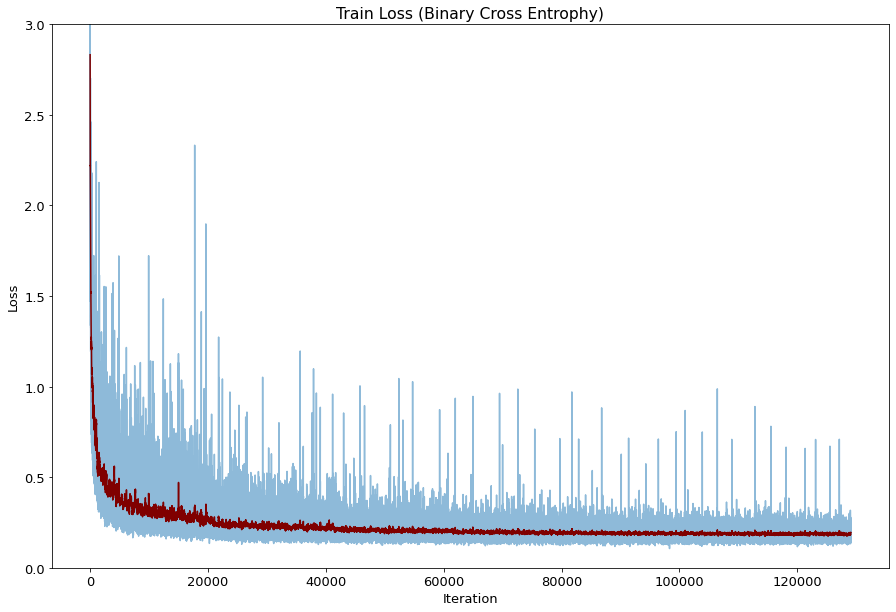

In [16]:
import matplotlib

matplotlib.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(15,10))

y = losses['train']
N = len(y)

K = 25
avg = []
for i in range(K, N-K):
  avg.append(sum(y[(i-K):(i+K+1)])/(2*K+1))
  
plt.plot(range(N), y, alpha=0.5)
plt.plot(range(K, N-K), avg, 'maroon')
plt.ylim(0, 3)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Train Loss (Binary Cross Entrophy)')
#plt.show()
plt.savefig('train_loss.png')

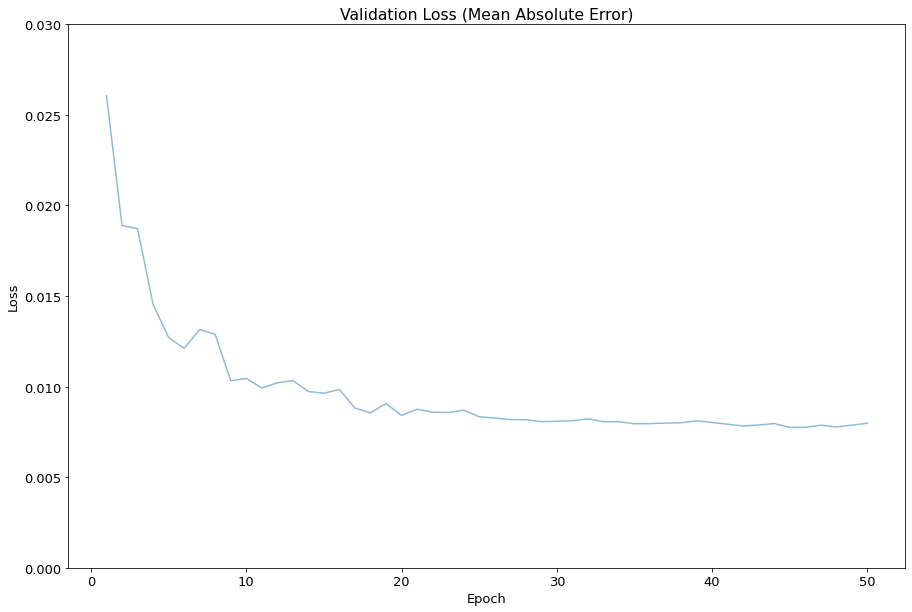

In [22]:
fig = plt.figure(figsize=(15,10))
y = losses['valid']

plt.plot(range(1, len(y)+1), y, alpha=0.5)
plt.ylim(0, 0.03)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss (Mean Absolute Error)')
#plt.show()
plt.savefig('val_loss.png')

## Test

In [11]:
def maskedImage(img, mask):
  img = img.cpu()
  img = np.einsum('ijk->jki', img)
  img = (127.5*(img+1)).astype(np.uint8)
  mask = mask.unsqueeze(2).detach().cpu().numpy()
  return cv2.cvtColor((img * mask).astype(np.uint8), cv2.COLOR_BGR2RGB)

In [12]:
test_dataset = MattingHuman(split='test')

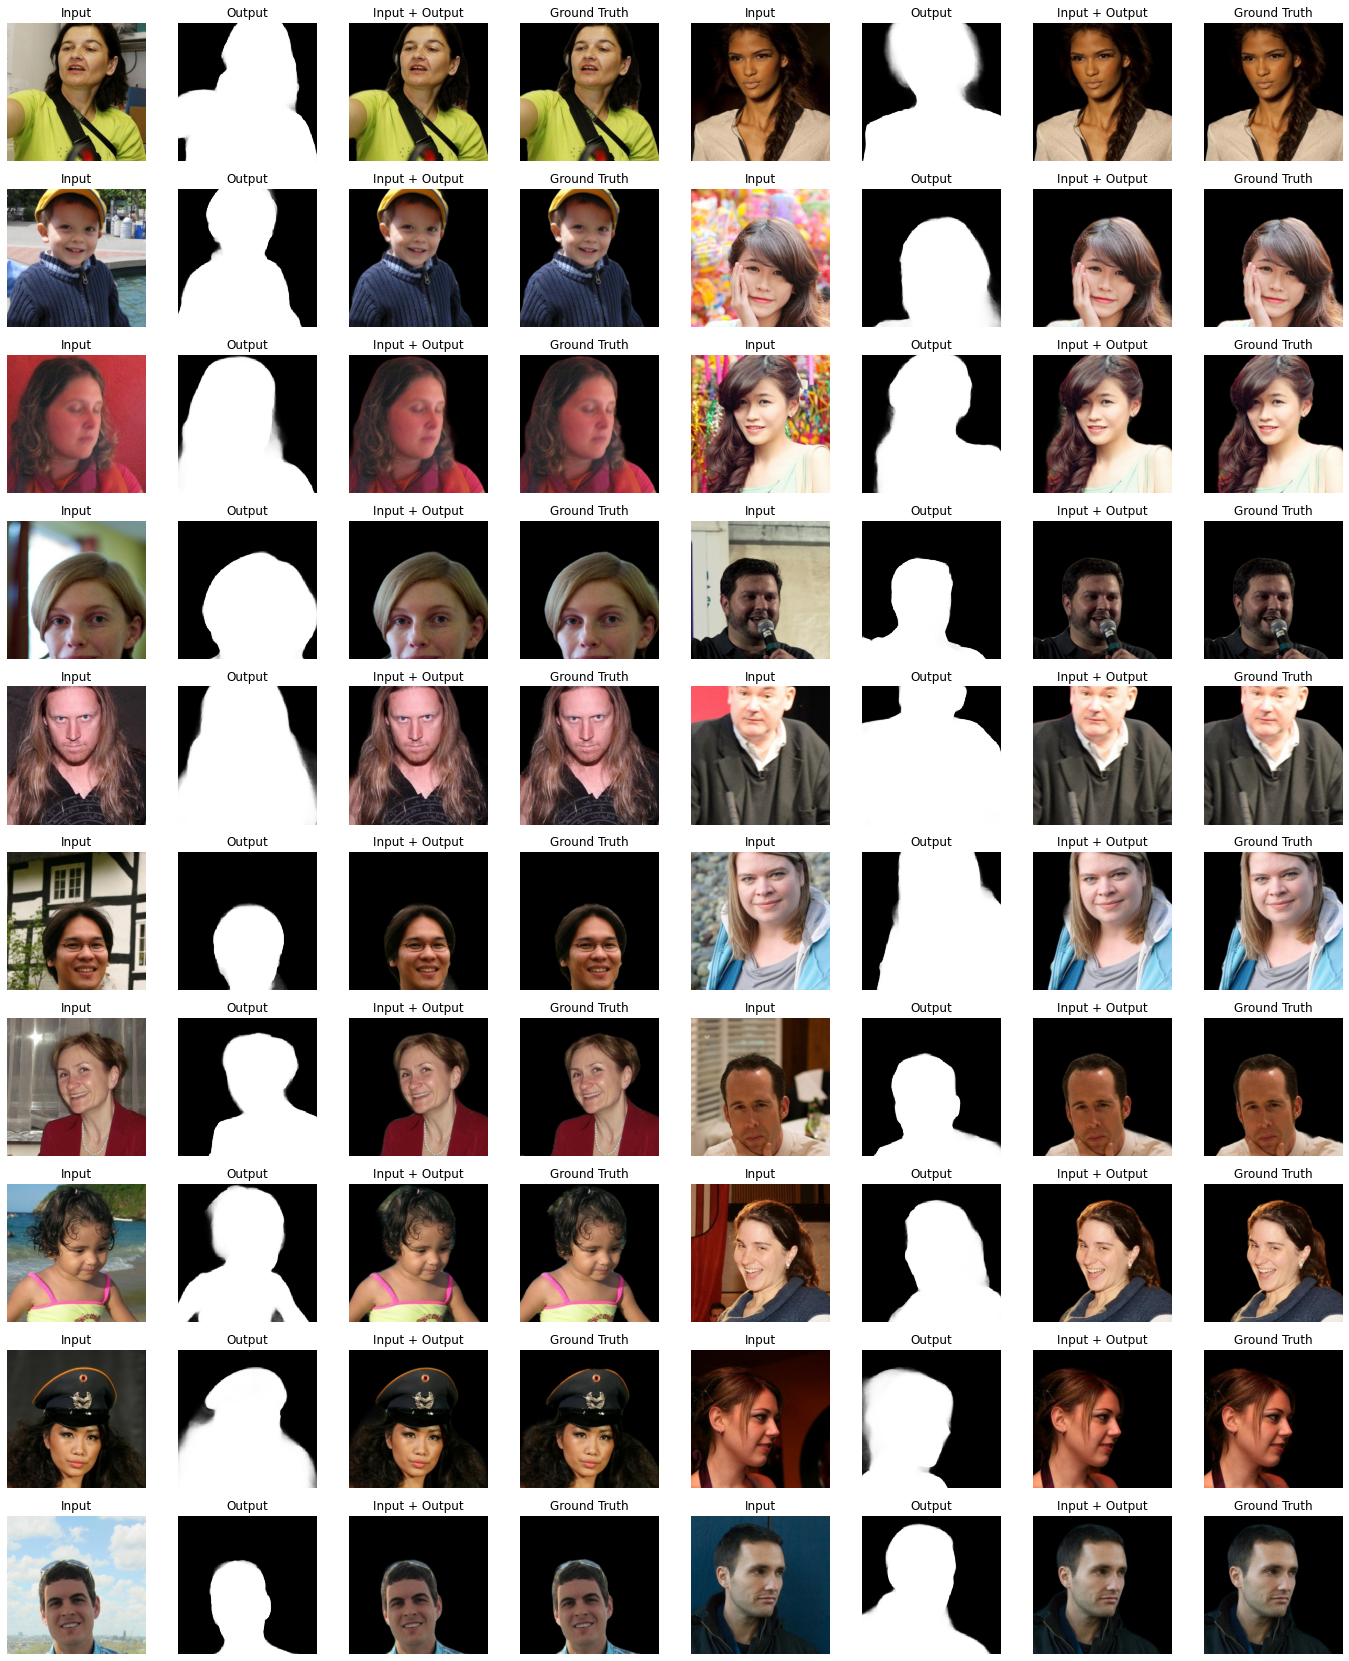

In [13]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=True, num_workers=workers)

input, target = next(iter(test_dataloader))
input = input.cuda()
target = target.cuda()
mask = model(input)[-1]

fig = plt.figure(figsize=(24, 30))
for k in range(20):
    ax = fig.add_subplot(10, 8, 4*k+1)
    ax.imshow(ImgForPlot(input[k].cpu()))
    ax.set_title('Input')
    ax.axis("off")

    ax = fig.add_subplot(10, 8, 4*k+2)
    ax.imshow(mask[k].detach().cpu(), cmap='gray', vmin=0, vmax=1, interpolation='none')
    ax.set_title('Output')
    ax.axis("off")

    ax = fig.add_subplot(10, 8, 4*k+3)
    ax.imshow(maskedImage(input[k], mask[k]))
    ax.set_title('Input + Output')
    ax.axis("off")
    
    ax = fig.add_subplot(10, 8, 4*k+4)
    ax.imshow(maskedImage(input[k], target[k]))
    ax.set_title('Ground Truth')
    ax.axis("off")

plt.savefig('result.png')

In [27]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=workers)

MAE = nn.L1Loss(reduction='mean')
test_loss = 0.
model.eval()
with torch.no_grad():
  for i in range(len(test_dataloader)):
    input, target = next(iter(test_dataloader))
    out = model(input.cuda())[-1]
    test_loss += MAE(out, target.cuda()).item() / len(test_dataloader)

print(test_loss)

0.008059208543272689


## Synthesize GIF

In [12]:
import cv2

def GifToFrame(path, size=256): 
    frames, masks = [], []
    gif = cv2.VideoCapture(gif_path)
    fps = gif.get(cv2.CAP_PROP_FPS)
    
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.CenterCrop(size),
                                    transforms.Resize(256),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    while True:
      ret, frame = gif.read()
      if ret:             
        frames.append(transform(frame))
            
      else:
        break
    
    print("GIF Info: %dx%d, %d frames, %d fps" % 
          (frames[0].shape[1], frames[0].shape[2], len(frames), fps))
    
    return frames, fps

GIF Info: 256x256, 70 frames, 14 fps


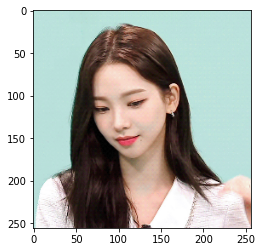

Save generated gif completely.
Save combined gif completely.
GIF Info: 256x256, 76 frames, 14 fps


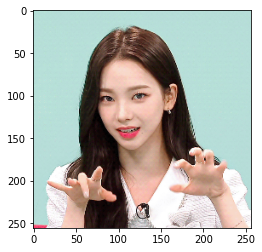

Save generated gif completely.
Save combined gif completely.
GIF Info: 256x256, 74 frames, 14 fps


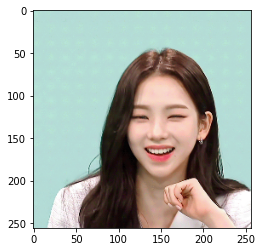

Save generated gif completely.
Save combined gif completely.
GIF Info: 256x256, 75 frames, 14 fps


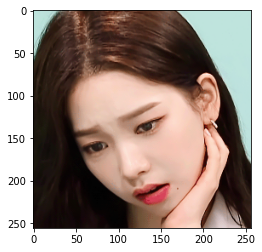

Save generated gif completely.
Save combined gif completely.
GIF Info: 256x256, 122 frames, 16 fps


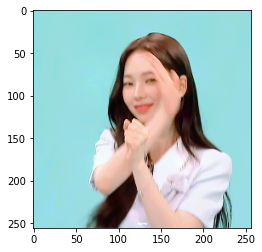

Save generated gif completely.
Save combined gif completely.
GIF Info: 256x256, 36 frames, 12 fps


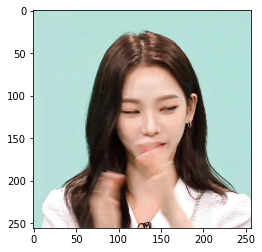

Save generated gif completely.
Save combined gif completely.


In [19]:
import imageio
import math

n_input = 16
sizes = [604, 594, 542, 524, 507, 664]

total_combs = []

for idx, size in enumerate(sizes):
  gif_path = "karina{}.gif".format(idx+1)

  resize, fps = GifToFrame(gif_path, size=size)
  plt.imshow(ImgForPlot(resize[0]))
  plt.show()

  # Change frames with generator
  N = math.ceil(len(resize) / n_input)
  outputs = []
  with torch.no_grad():
    for t in range(N):
      s = t * n_input
      e = min((t+1) * n_input, len(resize))
      inputs = torch.stack(resize[s:e]).cuda()
      outputs.append(model(inputs)[-1])
  outputs = torch.cat(outputs)

  # Save Generated GIF
  outputs = [maskedImage(resize[k], outputs[k]) for k in range(len(outputs))]
  gen_path = gif_path.replace(".gif","-generated.gif")
  imageio.mimsave(gen_path, outputs, format='GIF', fps=fps)
  print("Save generated gif completely.")

  combs = []
  for i in range(len(outputs)):
      comb = np.ndarray((256,512,3), dtype=np.uint8)
      comb[:, 0:256] = ImgForPlot(resize[i])
      comb[:, 256:512] = outputs[i]
      combs.append(comb)
  total_combs.append(combs)

  comb_path = gif_path.replace(".gif","-combined.gif")
  imageio.mimsave(comb_path, combs, format='GIF', fps=fps)
  print("Save combined gif completely.")